In [11]:
#imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import graphviz
from xgboost import plot_tree

In [12]:
#read CSVs
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')
products = pd.read_csv('data/products.csv')
departments = pd.read_csv('data/departments.csv')
aisles = pd.read_csv('data/aisles.csv')
orders = pd.read_csv('data/orders.csv')

order_products = pd.concat([order_products_prior,order_products_train])

In [3]:
dept_ = {'dept_1': 'frozen','dept_2': 'other','dept_3': 'bakery','dept_4': 'produce','dept_5': 'alcohol',
 'dept_6': 'international','dept_7': 'beverages','dept_8': 'pets','dept_9': 'dry goods pasta','dept_10': 'bulk',
 'dept_11': 'personal care','dept_12': 'meat seafood','dept_13': 'pantry','dept_14': 'breakfast',
 'dept_15': 'canned goods','dept_16': 'dairy eggs','dept_17': 'household','dept_18': 'babies',
 'dept_19': 'snacks','dept_20': 'deli','dept_21': 'missing'}

In [4]:
merge_dfs = orders.merge(order_products, on = 'order_id')
merge_dfs = merge_dfs.merge(products, on = 'product_id')
pbu = merge_dfs.merge(departments, on = 'department_id').sort_values(by = ['user_id','order_id','add_to_cart_order'])
pbu_dept = pbu[['user_id','department_id']]
pbu_dept = pbu_dept.groupby(['user_id','department_id']).agg({'department_id':'count'})\
.rename(columns = {'department_id':'dept_'})
pbu_dept = pbu_dept.unstack(level = 1, fill_value = 0)
pbu_dept = pbu_dept.astype(int)
pbu_dept = pbu_dept.reset_index()
pbu_dept.columns = [str(col[0]) + str(col[1]) for col in pbu_dept.columns]
pbu_dept["total_purchases"] = pbu_dept.loc[:,'dept_1':'dept_21'].sum(axis=1)
pbu_dept = pbu_dept.loc[:,'dept_1':'dept_21'].div(pbu_dept["total_purchases"], axis=0) *100
pbu_dept_id = pbu_dept
pbu_dept_id['user_id'] = pbu.user_id.unique()
pbu_dept = pbu_dept.set_index('user_id')
pbu_dept = pbu_dept.rename(dept_,axis = 1)
pbu_dept.head()

,frozen,other,bakery,produce,alcohol,international,beverages,pets,dry goods pasta,bulk,...,meat seafood,pantry,breakfast,canned goods,dairy eggs,household,babies,snacks,deli,missing
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.000000,7.142857,0.000000,0.000000,21.428571,0.0,0.000000,0.0,...,0.000000,1.428571,5.714286,0.000000,24.285714,4.285714,0.0,35.714286,0.000000,0.0
2,12.389381,0.0,0.884956,19.026549,0.000000,1.327434,3.982301,0.0,0.000000,0.0,...,0.442478,4.867257,1.327434,1.769912,21.681416,0.000000,0.0,20.796460,10.619469,0.0
3,6.818182,0.0,0.000000,43.181818,0.000000,0.000000,3.409091,0.0,4.545455,0.0,...,0.000000,4.545455,0.000000,0.000000,23.863636,1.136364,0.0,10.227273,2.272727,0.0
4,16.666667,0.0,11.111111,11.111111,11.111111,0.000000,16.666667,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,5.555556,0.000000,11.111111,0.0,5.555556,11.111111,0.0
5,4.347826,0.0,0.000000,50.000000,0.000000,8.695652,0.000000,0.0,2.173913,0.0,...,0.000000,6.521739,0.000000,2.173913,19.565217,2.173913,0.0,2.173913,2.173913,0.0


In [5]:
total_orders_by_user = orders.groupby('user_id').agg({'order_number':'max'})
median_order_number = total_orders_by_user.median()[0]
target = total_orders_by_user['order_number'] <= median_order_number
target = target.astype(int)
target.head() #target

user_id
1    0
2    0
3    0
4    1
5    1
Name: order_number, dtype: int32

In [6]:
round((target.sum()/target.shape[0])*100,2)

50.68

In [7]:
folds = 5
xgb_model = XGBClassifier()
xgb_model.fit(pbu_dept, target)
scores = cross_val_score(xgb_model,pbu_dept, target, cv=folds)
print(f'{folds}-Fold Crossvalidation Score: {round(scores.mean()*100,2)}%')

5-Fold Crossvalidation Score: 80.42%


ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

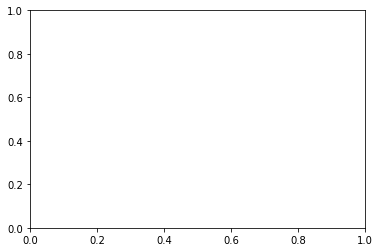

In [16]:
#import os
#os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

plot_tree(xgb_model, num_trees=0, rankdir='LR')
plt.show()

In [18]:
longer_users = pbu_dept[target == 1]
shorter_users = pbu_dept[target == 0]

In [19]:
def departments_segment(df,department,title,p = 50,threshold = 5):
    if department == 'all':
        df = df
    else:
        df = df[df[department] > p]
    group_size = df.shape[0]
    df = pd.DataFrame(zip(departments.department.tolist(),df.mean()),columns = ['departments', 'percent'])
    df = df.sort_values(by = 'percent',ascending = False)
    btt = df[df.percent <= threshold].percent.sum()
    df = df[df.percent > threshold]
    df = df.append({'departments':f'Below {threshold}%','percent':btt},ignore_index=True)
    color_dict = {'produce':'honeydew','dairy eggs':'mistyrose','beverages':'cornsilk',
    'snacks':'lightcyan','frozen':'lavender','pantry':'bisque',f'Below {threshold}%':'aliceblue','babies':'oldlace'}
    
    plt.pie(df.percent,
        colors = [color_dict.get(x, '#333333') for x in df.departments],
        labels = df.departments,
        autopct='%1.1f%%',
        shadow=False, 
        startangle=90)
    plt.title(title,fontsize = 15)

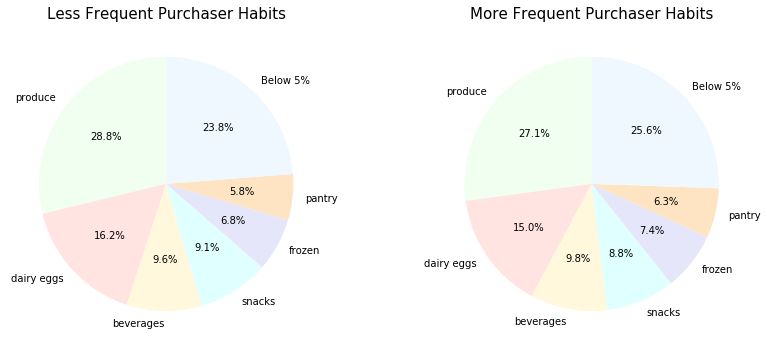

In [175]:
plt.figure(figsize = (15,15))

plt.subplot2grid(shape = (10,10),loc = (0,0),rowspan =4,colspan = 4)
departments_segment(shorter_users,'all','Less Frequent Purchaser Habits')

plt.subplot2grid(shape = (10,10),loc = (0,5),rowspan =4,colspan = 4)
departments_segment(longer_users,'all','More Frequent Purchaser Habits')

## Feature importance Graphs

In [133]:
fi = pd.DataFrame(zip(departments.department,xgb_model.feature_importances_),columns = ['department','feature_importance'])\
.sort_values(by = 'feature_importance',ascending = False)
fi

,department,feature_importance
5,international,0.169508
10,personal care,0.102504
13,breakfast,0.098703
16,household,0.067571
20,missing,0.063031
1,other,0.049760
9,bulk,0.046601
14,canned goods,0.044247
19,deli,0.041567
8,dry goods pasta,0.040150


In [143]:
fi_s = fi[fi.department.isin(['international','personal care','breakfast','frozen','dairy eggs','produce'])]
fi_s.head()

,department,feature_importance
5,international,0.169508
10,personal care,0.102504
13,breakfast,0.098703
0,frozen,0.025731
15,dairy eggs,0.015603


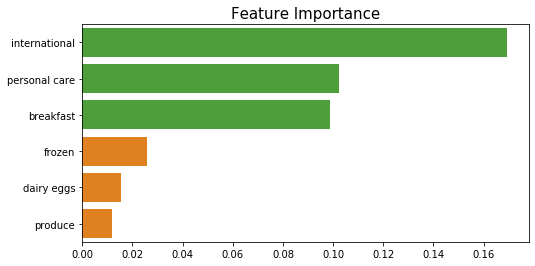

In [151]:
plt.figure(figsize = (8,4))
palette = sns.color_palette(['#43B02A','#43B02A','#43B02A','#FF8200','#FF8200','#FF8200'])
sns.barplot(y = fi_s.department, x = fi_s.feature_importance,palette =palette )
#            color = c(['#43B02A','#43B02A','#43B02A','#FF8200','#FF8200','#FF8200']))
plt.title(f'Feature Importance',fontsize = 15)
plt.xlabel('')
plt.ylabel('')
xticks_ = np.arange(0,0.17,0.02) 
#plt.xticks(ticks = xticks_ ,labels = [str(int(x*100)) + '%' for x in xticks_])
plt.show()

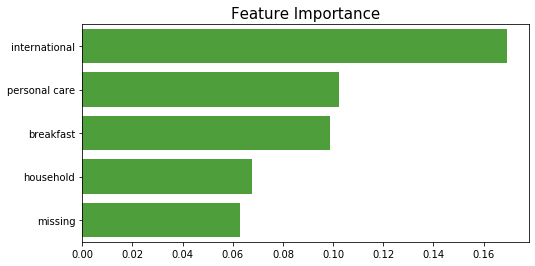

In [127]:
plt.figure(figsize = (8,4))
features_ = 5
sns.barplot(y = fi.department.head(features_), x = fi.feature_importance.head(features_),color = '#43B02A')
plt.title(f'Feature Importance',fontsize = 15)
plt.xlabel('')
plt.ylabel('')
xticks_ = np.arange(0,0.17,0.02) 
#plt.xticks(ticks = xticks_ ,labels = [str(int(x*100)) + '%' for x in xticks_])
plt.show()

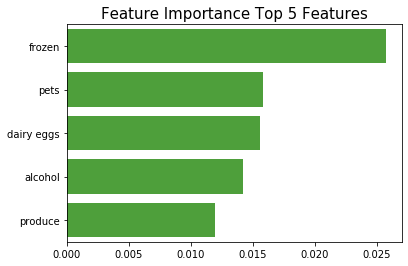

In [41]:
features_ = 5
sns.barplot(y = fi.department.tail(features_), x = fi.feature_importance.tail(features_),color = '#43B02A')
plt.title(f'Feature Importance Top {features_} Features',fontsize = 15)
plt.xlabel('')
plt.ylabel('')
#xticks_ = np.arange(0,0.17,0.02) 
#plt.xticks(ticks = xticks_ ,labels = [str(int(x*100)) + '%' for x in xticks_])
plt.show()

In [25]:
longer_users.head()

,frozen,other,bakery,produce,alcohol,international,beverages,pets,dry goods pasta,bulk,...,meat seafood,pantry,breakfast,canned goods,dairy eggs,household,babies,snacks,deli,missing
user_id,,,,,,,,,,,,,,,,,,,,,
4,16.666667,0.0,11.111111,11.111111,11.111111,0.000000,16.666667,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,5.555556,0.000000,11.111111,0.000000,5.555556,11.111111,0.0
5,4.347826,0.0,0.000000,50.000000,0.000000,8.695652,0.000000,0.0,2.173913,0.0,...,0.000000,6.521739,0.000000,2.173913,19.565217,2.173913,0.000000,2.173913,2.173913,0.0
6,0.000000,0.0,0.000000,42.857143,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,14.285714,7.142857,0.000000,21.428571,14.285714,0.000000,0.000000,0.000000,0.000000,0.0
8,0.000000,0.0,1.492537,59.701493,0.000000,1.492537,0.000000,0.0,1.492537,0.0,...,0.000000,5.970149,0.000000,8.955224,19.402985,0.000000,0.000000,0.000000,1.492537,0.0
9,1.020408,0.0,7.142857,8.163265,0.000000,0.000000,10.204082,0.0,0.000000,0.0,...,1.020408,4.081633,5.102041,1.020408,35.714286,1.020408,6.122449,14.285714,5.102041,0.0


In [26]:
shorter_users.head()

,frozen,other,bakery,produce,alcohol,international,beverages,pets,dry goods pasta,bulk,...,meat seafood,pantry,breakfast,canned goods,dairy eggs,household,babies,snacks,deli,missing
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.000000,7.142857,0.0,0.000000,21.428571,0.000000,0.000000,0.0,...,0.000000,1.428571,5.714286,0.000000,24.285714,4.285714,0.0,35.714286,0.000000,0.000000
2,12.389381,0.0,0.884956,19.026549,0.0,1.327434,3.982301,0.000000,0.000000,0.0,...,0.442478,4.867257,1.327434,1.769912,21.681416,0.000000,0.0,20.796460,10.619469,0.000000
3,6.818182,0.0,0.000000,43.181818,0.0,0.000000,3.409091,0.000000,4.545455,0.0,...,0.000000,4.545455,0.000000,0.000000,23.863636,1.136364,0.0,10.227273,2.272727,0.000000
7,1.860465,0.0,2.325581,26.976744,0.0,0.000000,26.046512,0.465116,0.000000,0.0,...,4.186047,4.651163,0.000000,2.790698,15.348837,0.465116,0.0,8.837209,6.046512,0.000000
13,0.000000,0.0,17.441860,19.767442,0.0,1.162791,2.325581,0.000000,3.488372,0.0,...,0.000000,2.325581,2.325581,5.813953,34.883721,0.000000,0.0,3.488372,0.000000,5.813953


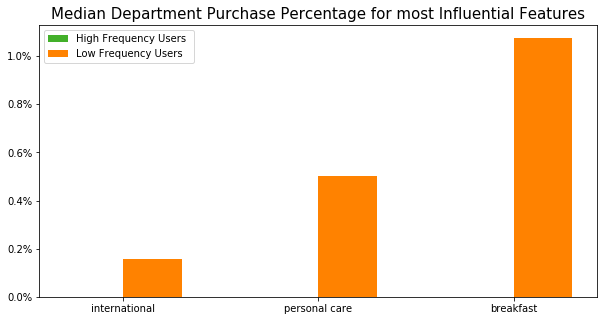

In [161]:
N = 3
top_features = fi.department.head(N).tolist()
bottom_features =  fi.department.tail(N)

tfi_l = longer_users[top_features]
tfi_s = shorter_users[top_features]

ind = np.arange(N)
plt.figure(figsize=(10,5))
width = 0.3       
plt.bar(ind, tfi_l.median() , width, label='High Frequency Users ', color = '#43B02A')
plt.bar(ind + width, tfi_s.median(), width, label='Low Frequency Users', color = '#FF8200')

plt.ylabel('')
plt.title('Median Department Purchase Percentage for most Influential Features',fontsize = 15)
plt.xticks(ind + width / 2, tfi_l.columns,rotation=0)
xticks_ = np.arange(0,1.1,0.2)
plt.yticks(ticks = xticks_ ,labels = [str(round(x,2)) + '%' for x in xticks_])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

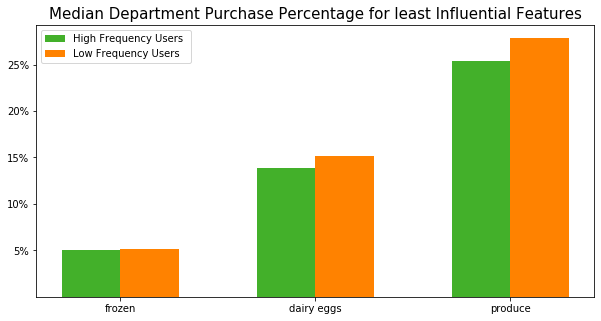

In [160]:
N = 3
bottom_features =  fi_s.department[-3:]

bfi_l = longer_users[bottom_features]
bfi_s = shorter_users[bottom_features]

ind = np.arange(N)
plt.figure(figsize=(10,5))
width = 0.3       
plt.bar(ind, bfi_l.median() , width, label='High Frequency Users ', color = '#43B02A')
plt.bar(ind + width, bfi_s.median(), width, label='Low Frequency Users', color = '#FF8200')

plt.ylabel('')
plt.title('Median Department Purchase Percentage for least Influential Features',fontsize = 15)
plt.xticks(ind + width / 2, bfi_l.columns,rotation=0)
xticks_ = np.arange(5,30,5)
plt.yticks(ticks = xticks_ ,labels = [str(round(x,2)) + '%' for x in xticks_])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

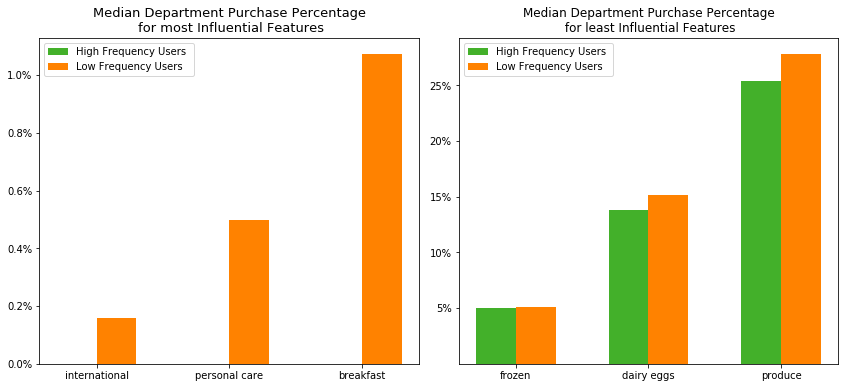

In [174]:
plt.figure(figsize = (15,10))
plt.subplot2grid(shape = (100,110),loc = (0,0),rowspan =60,colspan = 50)
N = 3
top_features = fi.department.head(N).tolist()
bottom_features =  fi.department.tail(N)

tfi_l = longer_users[top_features]
tfi_s = shorter_users[top_features]

ind = np.arange(N)
width = 0.3       
plt.bar(ind, tfi_l.median() , width, label='High Frequency Users ', color = '#43B02A')
plt.bar(ind + width, tfi_s.median(), width, label='Low Frequency Users', color = '#FF8200')

plt.ylabel('')
plt.title('Median Department Purchase Percentage\n for most Influential Features',fontsize = 13)
plt.xticks(ind + width / 2, tfi_l.columns,rotation=0)
xticks_ = np.arange(0,1.1,0.2)
plt.yticks(ticks = xticks_ ,labels = [str(round(x,2)) + '%' for x in xticks_])

# Finding the best position for legends and putting it
plt.legend(loc='best')

plt.subplot2grid(shape = (100,110),loc = (0,55),rowspan =60,colspan = 50)
N = 3
bottom_features =  fi_s.department[-3:]

bfi_l = longer_users[bottom_features]
bfi_s = shorter_users[bottom_features]

ind = np.arange(N)
width = 0.3       
plt.bar(ind, bfi_l.median() , width, label='High Frequency Users ', color = '#43B02A')
plt.bar(ind + width, bfi_s.median(), width, label='Low Frequency Users', color = '#FF8200')

plt.ylabel('')
plt.title('Median Department Purchase Percentage\n for least Influential Features',fontsize = 12)
plt.xticks(ind + width / 2, bfi_l.columns,rotation=0)
xticks_ = np.arange(5,30,5)
plt.yticks(ticks = xticks_ ,labels = [str(round(x,2)) + '%' for x in xticks_])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

---